## FiTLAM Eval for Quora

In [1]:
from fastai.text import *
import html

/home/ubuntu/anaconda3/envs/fastai/lib/python3.6/site-packages/matplotlib/__init__.py:1067: UserWarning: Duplicate key in file "/home/ubuntu/.config/matplotlib/matplotlibrc", line #2
  (fname, cnt))
/home/ubuntu/anaconda3/envs/fastai/lib/python3.6/site-packages/matplotlib/__init__.py:1067: UserWarning: Duplicate key in file "/home/ubuntu/.config/matplotlib/matplotlibrc", line #3
  (fname, cnt))


In [2]:
BOS = 'xbos'  # beginning-of-sentence tag
FLD = 'xfld'  # data field tag

PATH=Path('data/aclImdb/')

In [3]:
CLAS_PATH=Path('data/imdb_clas/')
CLAS_PATH.mkdir(exist_ok=True)

LM_PATH=Path('data/imdb_lm/')
LM_PATH.mkdir(exist_ok=True)

In [ ]:
QUESTION_PAIRS_FILE = '/home/ubuntu/.kaggle/competitions/quora-question-pairs/train.csv'
#print("Processing", QUESTION_PAIRS_FILE)

question1 = []
question2 = []
is_duplicate = []
with open(QUESTION_PAIRS_FILE, encoding='utf-8') as csvfile:
    reader = csv.DictReader(csvfile, delimiter=',')
    for row in reader:
        question1.append(row['question1'])
        question2.append(row['question2'])
        is_duplicate.append(int(row['is_duplicate']))

print('Question pairs: %d' % len(question1))

In [ ]:
t_QUESTION_PAIRS_FILE = '/home/ubuntu/.kaggle/competitions/quora-question-pairs/test.csv'
#print("Processing", QUESTION_PAIRS_FILE)

t_question1 = []
t_question2 = []
with open(t_QUESTION_PAIRS_FILE, encoding='utf-8') as csvfile:
    reader = csv.DictReader(csvfile, delimiter=',')
    for row in reader:
        t_question1.append(row['question1'])
        t_question2.append(row['question2'])

print('Question pairs: %d' % len(t_question2))

In [ ]:
ques = question1 + t_question1 + question2 + t_question2

In [ ]:
ques = ques[:4000000]

In [ ]:
trn_keep = np.random.rand(len(ques))>0.1
ques_trn = np.asarray(ques)[trn_keep]
ques_val = np.asarray(ques)[~trn_keep]

In [ ]:
tok = Tokenizer()
#texts = ques.items.astype(str)
tok_trn = tok.proc_all_mp(partition_by_cores(ques_trn[:900000]))

In [ ]:
tok_val = tok.proc_all_mp(partition_by_cores(ques_val[:300000]))

In [ ]:
freq = Counter(p for o in (tok_trn+tok_val) for p in o)
freq.most_common(5)

In [ ]:
max_vocab = 60000
min_freq = 2

In [ ]:
itos = [o for o,c in freq.most_common(max_vocab) if c>min_freq]
itos.insert(0, '_pad_')
itos.insert(0, '_unk_')

In [5]:
stoi = collections.defaultdict(lambda:0, {v:k for k,v in enumerate(itos)})
len(itos)

56001

In [ ]:
trn_lm = np.array([[stoi[o] for o in p] for p in tok_trn])
val_lm = np.array([[stoi[o] for o in p] for p in tok_val])

In [ ]:
np.save(LM_PATH/'tmp'/'trn_ids.npy', trn_lm)
np.save(LM_PATH/'tmp'/'val_ids.npy', val_lm)
pickle.dump(itos, open(LM_PATH/'tmp'/'itos.pkl', 'wb'))

In [4]:
trn_lm = np.load(LM_PATH/'tmp'/'trn_ids.npy')#[:900000]
val_lm = np.load(LM_PATH/'tmp'/'val_ids.npy')#[:300000]
itos = pickle.load(open(LM_PATH/'tmp'/'itos.pkl', 'rb'))

In [10]:
vs=len(itos)
vs,len(trn_lm)

(56001, 900000)

## wikitext103 conversion

In [11]:
em_sz,nh,nl = 400,1150,3

In [ ]:
PRE_PATH = PATH/'../wt103/models'/'wt103'
PRE_LM_PATH = PRE_PATH/'fwd_wt103.h5'

In [ ]:
wgts = torch.load(PRE_LM_PATH, map_location=lambda storage, loc: storage)

In [ ]:
enc_wgts = to_np(wgts['0.encoder.weight'])
row_m = enc_wgts.mean(0)

In [ ]:
itos2 = pickle.load((PRE_PATH/'itos_wt103.pkl').open('rb'))
stoi2 = collections.defaultdict(lambda:-1, {v:k for k,v in enumerate(itos2)})

In [ ]:
new_w = np.zeros((vs, em_sz), dtype=np.float32)
for i,w in enumerate(itos):
    r = stoi2[w]
    new_w[i] = enc_wgts[r] if r>=0 else row_m

In [ ]:
wgts['0.encoder.weight'] = T(new_w)
wgts['0.encoder_with_dropout.embed.weight'] = T(np.copy(new_w))
wgts['1.decoder.weight'] = T(np.copy(new_w))

## Language model

In [38]:
wd=1e-7
bptt=12
bs=250
opt_fn = partial(optim.Adam, betas=(0.8, 0.99))

In [39]:
trn_dl = LanguageModelLoader(np.concatenate(trn_lm), bs, bptt)
val_dl = LanguageModelLoader(np.concatenate(val_lm), bs, bptt)
md = LanguageModelData(PATH, 1, vs, trn_dl, val_dl, bs=bs, bptt=bptt)

In [40]:
drops = np.array([0.25, 0.1, 0.2, 0.02, 0.15])*0.2

In [41]:
learner= md.get_model(opt_fn, em_sz, nh, nl, 
    dropouti=drops[0], dropout=drops[1], wdrop=drops[2], dropoute=drops[3], dropouth=drops[4])
learner.metrics = [accuracy]
learner.freeze_to(-1)

In [ ]:
learner.model.load_state_dict(wgts)

In [42]:
torch.cuda.empty_cache()

In [ ]:
lr = 1e-3
learner.lr_find()

In [ ]:
learner.sched.plot()

In [31]:
learner.load('lm2')

In [32]:
learner.load_encoder('lm2_enc')

In [ ]:
learner.fit(lrs, 1, wds=wd, use_clr=(20,10), cycle_len=1)

In [22]:
learner.fit(lrs, 1, wds=wd, use_clr=(8,2), cycle_len=2)

epoch      trn_loss   val_loss   accuracy                     
    0      3.376454   3.659902   0.390786  
    1      3.291519   3.646026   0.394359                     



[array([3.64603]), 0.39435854565618644]

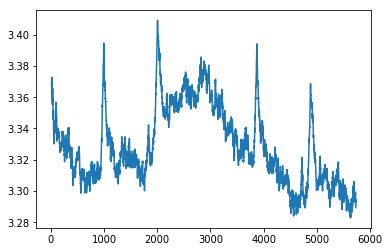

In [23]:
learner.sched.plot_loss()

In [33]:
learner.fit(lrs, 1, wds=wd, use_clr=(8,2), cycle_len=2)

epoch      trn_loss   val_loss   accuracy                     
    0      3.256174   3.646277   0.394441  
    1      3.242337   3.642499   0.394854                     



[array([3.6425]), 0.3948543235429418]

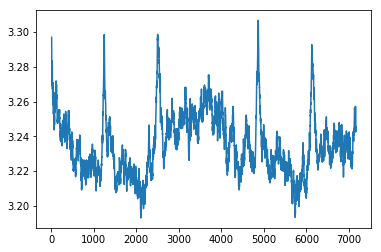

In [34]:
learner.sched.plot_loss()

In [43]:
learner.load('lm3')

In [44]:
learner.load_encoder('lm3_enc')

In [45]:
learner.fit(lrs, 1, wds=wd, use_clr=(8,2), cycle_len=2)

epoch      trn_loss   val_loss   accuracy                     
    0      3.188338   3.645451   0.394506  
    1      3.191483   3.642393   0.39501                      



[array([3.64239]), 0.3950102568379978]

In [46]:
learner.save('lm3')

In [47]:
learner.save_encoder('lm3_enc')

In [50]:
tok = Tokenizer()
learner.model.eval()
#np.array([[stoi[o] for o in p] for p in tok_q1])
num = ([[stoi[o] for o in p] for p in tok.proc_all(['will i go'],'en')])
list_of_nums = []
for i in range(8):
    needPrediction = np.array(num)
    probs = learner.model(V(needPrediction))
    #print (len(probs[2][-1][0][-1][-1][0]))
    #pred = to_np(probs[-1][-1][-1]).argmax()
    pred = to_np(probs[0][-1].exp()).argmax()
    list_of_nums += [itos[pred]]
    num = [np.append(needPrediction,pred)]
    #print (num)
    
print(list_of_nums)
encc =(probs[-1][-1][-1][-1].squeeze())
#(to_np(probs.unsqueeze(0)).shape)
#encc.unsqueeze(0).shape
to_np(learner.model[1].decoder(encc).exp()).argmax()

['to', 'be', 'a', 'person', '?', 'what', "'s", '"']


27

In [51]:
learner.model.eval()
num = ([[stoi[o] for o in p] for p in tok.proc_all(['is this the proper'],'en')]) # use a seed english sentence.
list_of_nums = []
for i in range(3): # predict next 3 words autoregressively
    needPrediction = np.array(num)
    probs = learner.model(V(needPrediction))
    encc =(probs[-1][-1][-1][-1].squeeze())
    pred = to_np(learner.model[1].decoder(encc).exp()).argmax()
    list_of_nums += [itos[pred]]
    num = [np.append(needPrediction,pred)]
    
print(list_of_nums)
encc =(probs[-1][-1][-1][-1].squeeze())
to_np(learner.model[1].decoder(encc).exp()).argmax() # this is the index of the next best prediction

['usage', 'of', 'the']


3

## Classifier tokens

In [52]:
QUESTION_PAIRS_FILE = '/home/ubuntu/.kaggle/competitions/quora-question-pairs/train.csv'

question1 = []
question2 = []
is_duplicate = []
with open(QUESTION_PAIRS_FILE, encoding='utf-8') as csvfile:
    reader = csv.DictReader(csvfile, delimiter=',')
    for row in reader:
      if len(row['question1'].split()) > 1 and len(row['question2'].split()) > 1:
        question1.append(row['question1'])
        question2.append(row['question2'])
        is_duplicate.append(int(row['is_duplicate']))

print('Question pairs: %d' % len(question1))

Question pairs: 404196


In [58]:
ques = question1 + question2
question2 = question2 + question1
question1 = ques
is_duplicate = is_duplicate + is_duplicate
len(question1),len(question2),len(is_duplicate)

(808392, 808392, 808392)

In [59]:
tok_q1 = Tokenizer.proc_all_mp(partition_by_cores(question1))
tok_q2 = Tokenizer.proc_all_mp(partition_by_cores(question2))

In [60]:
print (tok_q2[0])
len(tok_q1),len(tok_q2)

['what', 'is', 'the', 'step', 'by', 'step', 'guide', 'to', 'invest', 'in', 'share', 'market', '?']


(808392, 808392)

In [61]:
itos = pickle.load(open(LM_PATH/'tmp'/'itos.pkl', 'rb'))
stoi = collections.defaultdict(lambda:0, {v:k for k,v in enumerate(itos)})

In [62]:
q1 = np.array([[stoi[o] for o in p] for p in tok_q1])
q2 = np.array([[stoi[o] for o in p] for p in tok_q2])

In [63]:
np.save('q1_dbl.npy', q1)
np.save('q2_dbl.npy', q2)
np.save('dupe.npy', is_duplicate)

In [64]:
q1 = np.load('q1_dbl.npy')
q2 = np.load('q2_dbl.npy')
is_duplicate = np.load('dupe.npy')

In [ ]:
vs=len(itos) #vocab size
vs,len(q1)

In [66]:
trn_keep = np.random.rand(len(q1))>0.1
q1_trn = q1[trn_keep]
q2_trn = q2[trn_keep]
lbl_trn = np.asarray(is_duplicate)[trn_keep]
q1_val = q1[~trn_keep]
q2_val = q2[~trn_keep]
lbl_val = np.asarray(is_duplicate)[~trn_keep]

In [67]:
lbl_trn.shape,lbl_val.shape

((727602,), (80790,))

In [68]:
len(q1_trn),len(q2_trn),len(lbl_trn)

(727602, 727602, 727602)

In [69]:
np.save('q1_trn.npy', q1_trn)
np.save('q2_trn.npy', q2_trn)
np.save('q1_val.npy', q1_val)
np.save('q2_val.npy', q2_val)

np.save('lbl_trn.npy', lbl_trn)
np.save('lbl_val.npy', lbl_val)

In [5]:
q1_trn=np.load('q1_trn.npy')
q2_trn=np.load('q2_trn.npy')
q1_val=np.load('q1_val.npy')
q2_val=np.load('q2_val.npy')
lbl_trn=np.load('lbl_trn.npy')
lbl_val=np.load('lbl_val.npy')
itos = pickle.load(open(LM_PATH/'tmp'/'itos.pkl', 'rb'))
stoi = collections.defaultdict(lambda:0, {v:k for k,v in enumerate(itos)})

# Create dataloader for quora classifier

In [6]:
em_sz=400;vs=len(itos)

In [7]:
vs,em_sz

(56001, 400)

In [8]:
class PairDataset(Dataset):
    def __init__(self, X, y): self.x1,self.x2,self.y = X[0],X[1],y
    def __getitem__(self, idx): return A(self.x1[idx], self.x2[idx], (T(self.y[idx]).float()))
    def __len__(self): return len(self.x1)

In [9]:
trn_ds = PairDataset(X=[q1_trn,q2_trn],y=(lbl_trn).T)
val_ds = PairDataset(X=[q1_val,q2_val],y=(lbl_val).T)

In [86]:
trn_ds = PairDataset(X=[q1_trn[:100],q2_trn[:100]],y=(lbl_trn[:100]).T)
val_ds = PairDataset(X=[q1_val[:100],q2_val[:100]],y=(lbl_val[:100]).T)

In [10]:
trn_ds.__getitem__(15)

[array([  20,   11,  267,  113,   10,   33,  293,   32,    3,  298,   79, 5140,    2]),
 array([    6,    11,   654,   127,    76, 11443,     8,   138,     2]),
 array([0.], dtype=float32)]

In [11]:
bs=170
#bs=4

In [12]:
trn_dl = DataLoader(trn_ds, bs, transpose=True, transpose_y=True, num_workers=1, 
                    pad_idx=1, pre_pad=False) #, sampler=trn_samp)
val_dl = DataLoader(val_ds, bs, transpose=True, transpose_y=True, num_workers=1, 
                    pad_idx=1, pre_pad=False) #, sampler=val_samp)
md = ModelData(PATH, trn_dl, val_dl)

In [13]:
it = iter(trn_dl)
its = [next(it) for i in range(5)]
[(len(x1),len(x2),len(y)) for x1,x2,y in its]
[((x1.shape),(x2.shape),(y.shape)) for x1,x2,y in its]

[(torch.Size([32, 170]), torch.Size([40, 170]), torch.Size([170, 1])),
 (torch.Size([51, 170]), torch.Size([43, 170]), torch.Size([170, 1])),
 (torch.Size([37, 170]), torch.Size([40, 170]), torch.Size([170, 1])),
 (torch.Size([36, 170]), torch.Size([39, 170]), torch.Size([170, 1])),
 (torch.Size([33, 170]), torch.Size([48, 170]), torch.Size([170, 1]))]

## Classifier

In [14]:
bptt,em_sz,nh,nl = 20,400,1150,3
vs = len(itos)
opt_fn = partial(optim.Adam, betas=(0.8, 0.99))

In [15]:
# part 1
dps = np.array([0.4, 0.5, 0.05, 0.3, 0.1])

In [19]:
dps = np.array([0.4,0.5,0.05,0.3,0.4])*0.3

In [20]:
class PairBatchRNN(RNN_Encoder):
    def __init__(self, bptt, max_seq, *args, **kwargs):
        self.max_seq,self.bptt = max_seq,bptt
        super().__init__(*args, **kwargs)

    def concat(self, arrs):
        return [torch.cat([l[si] for l in arrs]) for si in range(len(arrs[0]))]

    def forward(self, input):
        #print (input[0].shape)
        sl,bs = input[0].size()
        for l in self.hidden:
            for h in l: h.data.zero_()
        raw_outputs0, raw_outputs1, outputs0, outputs1 = [],[],[],[]
        r0, o0 = super().forward(input[0])
        r1, o1 = super().forward(input[1])
        raw_outputs0.append(r0)
        raw_outputs1.append(r1)
        outputs0.append(o0)
        outputs1.append(o1)
        return self.concat(raw_outputs0), self.concat(raw_outputs1), self.concat(outputs0), self.concat(outputs1)

In [21]:
class LinearComparator(nn.Module):
    initrange=0.1
    def __init__(self, n_out, nhid, dropout, tie_encoder=None):
        super().__init__()
        self.decoder = nn.Linear(nhid, 200, bias=False)
        self.decoder2 = nn.Linear(200, 50, bias=False)
        self.decoder3 = nn.Linear(100, 1, bias=False)
        self.decoder.weight.data.uniform_(-self.initrange, self.initrange)
        self.decoder2.weight.data.uniform_(-self.initrange, self.initrange)
        self.decoder3.weight.data.uniform_(-self.initrange, self.initrange)
        self.dropout = LockedDropout(dropout)
        self.bn = nn.BatchNorm1d(200)
        if tie_encoder: self.decoder.weight = tie_encoder.weight

    def forward(self, input):
        raw_outputs0, raw_outputs1, outputs0, outputs1 = input
        output0 = self.dropout(outputs0[-1])
        output1 = self.dropout(outputs1[-1])
        
        decoded0 = self.decoder(output0[-1].view(output0.size(1), output0.size(2)))
        decoded1 = self.decoder(output1[-1].view(output1.size(1), output1.size(2)))
        result0 = F.relu(decoded0.view(decoded0.size(1),-1))
        result1 = F.relu(decoded1.view(decoded1.size(1),-1))
        
        result0 = F.relu(self.decoder2(self.bn(result0.view(result0.size(1),-1))))
        result1 = F.relu(self.decoder2(self.bn(result1.view(result1.size(1),-1))))
        
        result0 = self.decoder3(torch.cat((result0,result1),1))
        return result0, raw_outputs1, outputs1

In [22]:
#need to clean-up unwanted parameters
def get_rnn_comparator(bptt, max_seq, n_class, n_tok, emb_sz, n_hid, n_layers, pad_token, layers, drops, bidir=False,
                      dropouth=0.3, dropouti=0.5, dropoute=0.1, wdrop=0.5):
    rnn_enc = PairBatchRNN(bptt, max_seq, n_tok, emb_sz, n_hid, n_layers, pad_token=pad_token, bidir=bidir,
                      dropouth=dropouth, dropouti=dropouti, dropoute=dropoute, wdrop=wdrop)
    return SequentialRNN(rnn_enc, LinearComparator(n_tok, emb_sz, dropout=0.2, tie_encoder=None))

In [23]:
#need to clean-up unwanted parameters
m = get_rnn_comparator(bptt, 20*70, 0, vs, emb_sz=em_sz, n_hid=nh, n_layers=nl, pad_token=1,
          layers=[em_sz*3, 50, 0], drops=[dps[4], 0.1],
          dropouti=dps[0], wdrop=dps[1], dropoute=dps[2], dropouth=dps[3])

In [24]:
# def binary_loss_crit(y, p):
#     p = p.clamp(min=0.001,max=0.999)
#     return torch.mean(-(y * torch.log(p) + (1-y)*torch.log(1-p)))

In [25]:
opt_fn = partial(optim.Adam, betas=(0.7, 0.99))

In [26]:
learn = RNN_Learner(md, TextModel(to_gpu(m)), opt_fn=opt_fn)
#learn.crit=binary_loss_crit
learn.crit=nn.BCEWithLogitsLoss()
learn.clip=.25
#learn.metrics = [accuracy]

In [27]:
lr=3e-3
lrm = 2.6
lrs = np.array([lr/(lrm**4), lr/(lrm**3), lr/(lrm**2), lr/lrm, lr])

In [28]:
lrs=np.array([1e-4,1e-4,1e-4,1e-3,1e-2])

In [29]:
wd = 1e-7
wd = 0
learn.load_encoder('lm3_enc')

In [146]:
learn.freeze_to(-1)

In [ ]:
learn.lr_find(start_lr=lrs*5, end_lr=lrs*50, linear=False)
learn.sched.plot()

In [103]:
learn.fit(lrs/10, 1, wds=wd, cycle_len=1, use_clr=(32,3))

epoch      trn_loss   val_loss                             
    0      0.677216   0.643135  


[array([0.64314])]

In [33]:
learn.fit(lrs/10, 1, wds=wd, cycle_len=1, use_clr=(10,3))

  1%|          | 20/2426 [00:03<07:05,  5.65it/s, loss=0.654]
epoch      trn_loss   val_loss                                 
    0      0.635892   0.655194  



[array([0.65519])]

In [34]:
learn.save('clas_0')

In [147]:
learn.load('clas_0')

In [31]:
learn.unfreeze()

In [32]:
learn.fit(lrs, 1, wds=wd, cycle_len=14, use_clr=(32,10))

epoch      trn_loss   val_loss                                 
    0      0.458041   0.474792  
    1      0.405665   0.432354                                 
    2      0.361551   0.366269                                 
    3      0.329577   0.351058                                 
    4      0.295354   0.335803                                 
    5      0.288737   0.326181                                 
    6      0.29712    0.39789                                  
    7      0.2375     0.30613                                  
    8      0.2161     0.2946                                   
    9      0.196152   0.281593                                 
    10     0.187022   0.274878                                 
    11     0.174099   0.257199                                 
    12     0.170549   0.258585                                 
    13     0.159208   0.261807                                 



[array([0.26181])]

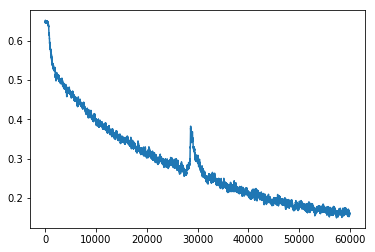

In [33]:
learn.sched.plot_loss()

In [34]:
learn.save('clas_2')

In [35]:
learn.fit(lrs, 1, wds=wd, cycle_len=5, use_clr=(32,10))

epoch      trn_loss   val_loss                                 
    0      0.203828   0.259417  
    1      0.182622   0.239604                                 
    2      0.152919   0.235551                                 
    3      0.138268   0.222716                                 
    4      0.125921   0.22654                                  



[array([0.22654])]

In [36]:
learn.save('clas_3')

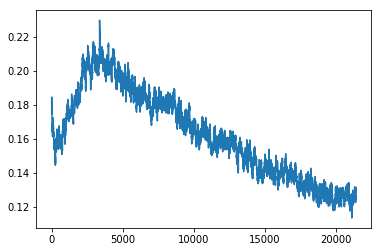

In [37]:
learn.sched.plot_loss()

In [38]:
learn.fit(lrs/2, 1, wds=wd, cycle_len=5, use_clr=(8,2))

epoch      trn_loss   val_loss                                 
    0      0.130013   0.213987  
    1      0.124487   0.217585                                 
    2      0.126801   0.316775                                 
    3      0.116902   0.199518                                 
    4      0.106528   0.198628                                  



[array([0.19863])]

In [39]:
learn.save('clas_4')

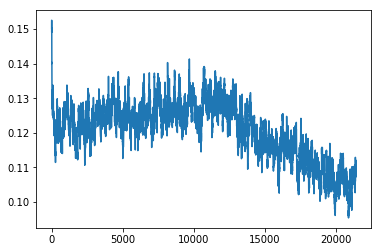

In [40]:
learn.sched.plot_loss()

In [41]:
learn.fit(lrs, 1, wds=wd, cycle_len=5, use_clr=(32,10))

epoch      trn_loss   val_loss                                 
    0      0.140054   0.204855  
    1      0.125858   0.220461                                 
    2      0.117512   0.214747                                 
    3      0.096485   0.241709                                  
    4      0.083878   0.255403                                  



[array([0.2554])]

In [43]:
learn.save('clas_5') #yeah....classi-5!

Model is overfitting and we can increase dropout and train some more.
_The kaggle quora competition leaderboard has a winning log loss of 0.112_

## More techniques to try

* Bi-Dir
* Concat pooling
* Further BPTT annealing - _Periodically make the matrix go from short-stout to tall-lean...decrease BPTT and increase bs_
* _Try cosine/arccos similarity again_
* _Train with 1-cycle beta_
* _Pointer Cache for extra low perplexity_